In [1]:
import pandas as pd
import json
import numpy as np
import requests
import urllib
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import textdistance
import string
import re
from dateutil import parser
import time

In [2]:
with open('data/final/sampled_references_en.json','r',encoding='utf-8') as f:
    json_en = json.load(f)
    df = pd.DataFrame(json_en)
df['verified'] = False
df.shape

(340, 10)

In [3]:
def norm_string(s):
    #return s.lower().translate(str.maketrans('', '', string.punctuation))
    return re.sub('\W+','', s).lower()

def compare(s1,s2):
    return textdistance.levenshtein.normalized_similarity(norm_string(s1),norm_string(s2))

## We check the netlocs to see what checks can be automatized

In [4]:
urlparse_df = df['url'].transform(urlparse)
urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
df[['scheme','netloc','path','params','query','fragment']] = urlparse_df

In [5]:
pd.DataFrame(df['netloc'].value_counts()).reset_index().head(10)

,index,netloc
0,www.ebi.ac.uk,98
1,eutils.ncbi.nlm.nih.gov,59
2,pubmed.ncbi.nlm.nih.gov,35
3,www.ncbi.nlm.nih.gov,25
4,api.crossref.org,25
5,europepmc.org,25
6,en.wikipedia.org,11
7,geonames.nga.mil,11
8,viaf.org,5
9,wikidata-externalid-url.toolforge.org,4


In [6]:
df[df['netloc'] == 'www.ebi.ac.uk']

,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
4,0490ec30a46b85f29b3d7e2d7bbb91494b72bd3b,https://www.ebi.ac.uk/europepmc/webservices/re...,{'stated in': 'wikibase-item:>Europe PubMed Ce...,en,Q74617387-57B087E1-F549-4A24-A0FE-26ECB0AC3DE8,[Scoring system of late effects of radiations ...,instance of,scholarly article,0,False,https,www.ebi.ac.uk,/europepmc/webservices/rest/search,,query=EXT_ID:9614880%20AND%20SRC:MED&resulttyp...,
9,760fabe1d62b75f0ae7983bae74cca54cead6178,https://www.ebi.ac.uk/europepmc/webservices/re...,{'stated in': 'wikibase-item:>Europe PubMed Ce...,en,Q73678964-BAC497AA-FE49-4B8E-B2D9-C5626FF4D420,Persistent hyperplastic primary vitreous assoc...,publication date,2000-04-01T00:00:00Z,0,False,https,www.ebi.ac.uk,/europepmc/webservices/rest/search,,query=EXT_ID:10766149%20AND%20SRC:MED&resultty...,
12,4df038777ecf889d12435ee1f8a42d4e72bfc9cd,http://www.ebi.ac.uk/interpro/protein/Q8N4F0,{'stated in': 'wikibase-item:>InterPro Release...,en,Q21115554-EF10816C-E214-4ACC-BA3C-DEF1D0293264,BPI fold containing family B member 2,part of,Lipid binding protein BPI/LBP,0,False,http,www.ebi.ac.uk,/interpro/protein/Q8N4F0,,,
13,06ab2001c579fbfc1e017427445fbbcb1c3647d8,https://www.ebi.ac.uk/europepmc/webservices/re...,{'stated in': 'wikibase-item:>Europe PubMed Ce...,en,Q37145451-315E8725-CB85-4C5D-B365-E3E75D8B2AE2,Epigenetic mechanisms mediating the long-term ...,published in,Neuroscience & Biobehavioral Reviews,0,False,https,www.ebi.ac.uk,/europepmc/webservices/rest/search,,query=EXT_ID:18430469%20AND%20SRC:MED&resultty...,
17,0338e0ca86b3cf02c4d0441ce533506d460e8122,https://www.ebi.ac.uk/europepmc/webservices/re...,{'stated in': 'wikibase-item:>Europe PubMed Ce...,en,Q74470273-1E77C586-EE50-4097-B871-A92AE194FEEC,f-f excitations by resonant electron-exchange ...,DOI,10.1103/PHYSREVLETT.55.2995,0,False,https,www.ebi.ac.uk,/europepmc/webservices/rest/search,,query=EXT_ID:10032295%20AND%20SRC:MED&resultty...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,846de01d939bba6a6c2da50f94499978772c484e,https://www.ebi.ac.uk/europepmc/webservices/re...,{'stated in': 'wikibase-item:>Europe PubMed Ce...,en,Q74616796-28A1F2E3-B68B-4452-A741-9413DC18DB02,[Studies on tannins from Tripterygium hypoglau...,published in,Zhongguo Zhongyao Zazhi,0,False,https,www.ebi.ac.uk,/europepmc/webservices/rest/search,,query=EXT_ID:11599388%20AND%20SRC:MED&resultty...,
327,971bfd94700f823629344511661240264cf7a977,https://www.ebi.ac.uk/europepmc/webservices/re...,{'stated in': 'wikibase-item:>Europe PubMed Ce...,en,Q34516265-09E704FC-6D71-49E3-8C6E-20A5E50874BF,The counterflow transport of sterols and PI4P.,author,Bruno Antonny,0,False,https,www.ebi.ac.uk,/europepmc/webservices/rest/search,,query=EXT_ID:26928592%20AND%20SRC:MED&resultty...,
336,09947823953f0164b4343d9569ee05a1493afe66,https://www.ebi.ac.uk/europepmc/webservices/re...,{'stated in': 'wikibase-item:>Europe PubMed Ce...,en,Q73895102-DF47D183-AAD7-4CD9-AB23-CA10B9EFDFB1,[An experimental study of the anti-ulcer prope...,published in,Eksperimental'naia i klinicheskaia farmakologiia,0,False,https,www.ebi.ac.uk,/europepmc/webservices/rest/search,,query=EXT_ID:9376756%20AND%20SRC:MED&resulttyp...,
338,298430d68b58c18aba0ed9796e849eb200d2cf89,http://www.ebi.ac.uk/QuickGO/annotations?geneP...,"{'retrieved': 'time:>+2019-02-14T00:00:00Z', '...",en,Q24224834-C74B1DA9-AB50-4691-94C7-BAE0AB5073F9,MFS permease blr6967,cell component,membrane,0,False,http,www.ebi.ac.uk,/QuickGO/annotations,,geneProductId=UniProtKB:Q89EV3,


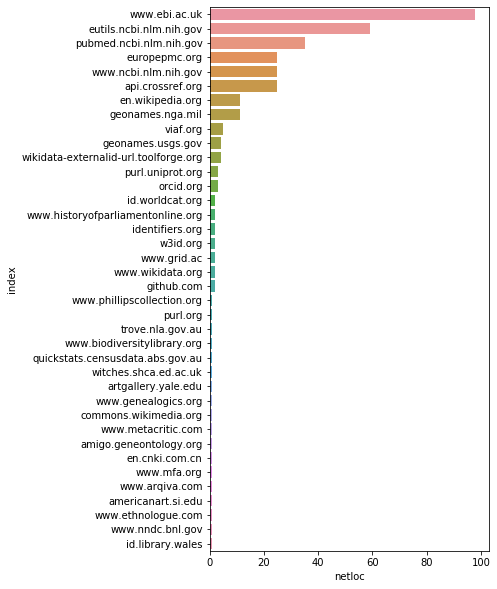

In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
sns.barplot(data = pd.DataFrame(df['netloc'].value_counts()).reset_index(),
           y = 'index',x='netloc', ax=ax)
plt.show()

## www.ebi.ac.uk
We see here that there are many types of predicates, but automating these many checks may be done.

Some here have the path for the api, some do not. We can only check those directed at the API, so we filter them. The ones filtered out are protein and gene databases which we'll check later.

### Article API

In [7]:
df_ebi = df[df['netloc'] == 'www.ebi.ac.uk']
df_ebi_api = df_ebi[df_ebi['path'] == '/europepmc/webservices/rest/search']
df_ebi_api['predicate'].value_counts(), df_ebi_api.shape[0]

(author name string    21
 PubMed ID              9
 published in           9
 publication date       8
 volume                 8
 instance of            7
 title                  6
 DOI                    5
 page(s)                5
 issue                  4
 author                 2
 PMCID                  1
 Name: predicate, dtype: int64,
 85)

In [8]:
def verify_ebi_api(row, verbose=True):
#for i, row in df_en_ebi_api.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    d = requests.get(row['url']).json()['resultList']['result']
    
    if compare(subject, d[0]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d[0]['title'])
        #break
        return found
    if predicate == 'instance of':
        value = d[0]['pubTypeList']['pubType']
        if obj == 'scholarly article' and 'Journal Article' in value:
            found = True            
    elif predicate == 'publication date':
        value = d[0]['firstPublicationDate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
    elif predicate == 'published in':
        obj = obj.replace('The BMJ','British medical journal')
        value = d[0]['journalInfo']['journal']['title']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = d[0]['doi']
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'author name string' or predicate == 'author':
        value = d[0]['authorList']['author']
        for author in value:
            #if 'fullName' in author:
            #    print('Full name:',author['fullName'])
            #if 'firstName' in author:
            #    print('First and last names:',author['firstName'] + ' ' + author['lastName'])
            #print(obj)
            if 'fullName' in author and compare(obj, author['fullName']) >= 0.99:
                found = True
            elif 'firstName' in author and compare(obj, author['firstName'] + ' ' + author['lastName']) >= 0.99:
                found = True
    elif predicate == 'volume':
        value = d[0]['journalInfo']['volume']
        if value == obj:
            found = True
    elif predicate == 'page(s)':
        value = d[0]['pageInfo']
        if value == obj:
            found = True
    elif predicate == 'issue':
        value = d[0]['journalInfo']['issue']
        if value == obj:
            found = True
    elif predicate == 'PubMed ID':
        value = d[0]['id']
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'title':
        value = d[0]['title']
        if compare(obj, d[0]['title']) >= 0.9:
            found = True
    elif predicate == 'PMCID':
        value = d[0]['pmcid']
        if ('PMC'+obj) == value:
            found = True
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_ebi_api_verified = df_ebi_api.apply(verify_ebi_api,axis=1)
print('{}% are confirmed'.format(100*df_ebi_api_verified.sum()/len(df_ebi_api_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_ebi_api.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_ebi_api[df_ebi_api_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


### The rest of ebi.ac.uk (genes and proteins)

Conclusion: Names in subject / object differ too much from those obtained in the APIs, and there seems to be great need of domain knowledge (biology) to navigate through the information, making automatically checking the API daunting and approaches manual effort.

## eutils.ncbi.nlm.nih.gov
We see that there is only one type of predicate, and automating it may be done

In [9]:
df_eutils = df[df['netloc'] == 'eutils.ncbi.nlm.nih.gov']
df_eutils['predicate'].value_counts()

cites work    59
Name: predicate, dtype: int64

In [11]:
sim_thr = 0.6
def get_title_eutils(db,pmc_id):    
    while 1:
        resp = requests.get(
                'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db={}&id={}&retmode=json&api_key=8f63f07f7fdb3b58681e7144dc40b330a608'.format(db,pmc_id),
                timeout=(60*20,60*20)
            )
        if resp.status_code == 200:
            break
        else:
            time.sleep(2)
            continue
    try:
        return resp.json()['result'][pmc_id]['title']
    except KeyError as e:
        return 'no-title'
    except Exception as e: 
        print(resp.json(), e)
        return str(e)


def verify_eutils(row, verbose=True):
#for i, row in df_en_eutils.iterrows():
    found_i = False
    while 1:
        resp = requests.get(
                row['url'],
                timeout=(60*20,60*20)
            )
        if resp.status_code == 200:
            break
        else:
            print(resp.status_code)
            time.sleep(2)
            continue
    d = resp.json()
    s = get_title_eutils(d['linksets'][0]['dbfrom'],d['linksets'][0]['ids'][0])

    if textdistance.levenshtein.normalized_similarity(norm_string(row['subject']),  norm_string(s)) <= sim_thr:
        if verbose:            
            print('Subject not found')
            print(norm_string(row['subject']),row['subject'])
            print(norm_string(s),s)
        return False
        #found.append(False)
        #continue
    os = []
    for l in d['linksets'][0]['linksetdbs'][0]['links']:
        o = get_title_eutils(d['linksets'][0]['linksetdbs'][0]['dbto'],l)
        dist = textdistance.levenshtein.normalized_similarity(norm_string(o),norm_string(row['object']))
        if dist >= sim_thr:
            found_i = True
            break
        elif dist >= sim_thr/3:
            os.append(o)
    if verbose and not found_i:
        print('Object not found')
        print(norm_string(row['object']))
        print([norm_string(o) for o in os])
    return found_i    
    #found.append(found_i)
    
df_eutils_verified = df_eutils.apply(verify_eutils,axis=1)
print('{}% are confirmed'.format(100*df_eutils_verified.sum()/len(df_eutils_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_eutils.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_eutils[df_eutils_verified == False]

Object not found
periodontalprobingwhatdoesitmean
['doesimplantstagingchoiceaffectcrestalboneloss', 'factorsinfluencingthepreservationoftheperiimplantmarginalbone', 'aestheticsinoralimplantologybiologicalclinicalsurgicalandprostheticaspects', 'submergedornonsubmergedhealingofendosseousimplantstobeusedintherehabilitationofpartiallydentatepatients', 'thepalataladvancedflapapedicleflapforprimarycoverageofimmediatelyplacedimplants', 'a5yearprospectiveclinicalandradiographicstudyofnonsubmergeddentalimplants', 'regenerationofgingivalpapillaeaftersingleimplanttreatment', 'thesofttissueresponsetoosseointegrateddentalimplants', 'theperiimplanthardandsofttissuesatdifferentimplantsystemsacomparativestudyinthedog', 'therelationshipbetweenthewidthofkeratinizedgingivaandgingivalhealth']
98.30508474576271% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
270,085b0413636718e439a043e47f3f2d8017f63d2e,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,{'stated in': 'wikibase-item:>PubMed Central->...,en,Q40034608-BC94DD0F-EE7D-4CAF-BCA0-3F52CEAE6863,A Comparative Study of Clinical Parameters in ...,cites work,Periodontal probing: what does it mean?,0,False,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/elink.fcgi,,dbfrom=pmc&linkname=pmc_refs_pubmed&retmode=js...,


# pubmed.ncbi.nlm.nih.gov

These use a very similar json structure to ebi.ac.uk and the same endpoint as eutils so it is also possible to automatize

In [12]:
df_pubmed = df[df['netloc'] == 'pubmed.ncbi.nlm.nih.gov']
df_pubmed['predicate'].value_counts(), df_pubmed.shape

(author name string    9
 publication date      4
 DOI                   4
 PubMed ID             3
 instance of           3
 author                3
 title                 2
 page(s)               2
 volume                2
 published in          2
 issue                 1
 Name: predicate, dtype: int64,
 (35, 16))

In [13]:
def verify_pubmed(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    pubmed_id = row['url'].split('/')[-1]
    while 1:
        resp = requests.get(
            'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={}&retmode=json'.format(pubmed_id)
        )
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={}&retmode=json'.format(pubmed_id))
        print(resp)
        return False
    if compare(subject, d['result'][pubmed_id]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d['result'][pubmed_id]['title'])
        #break
        return found
        
    if predicate == 'instance of':
        value = d['result'][pubmed_id]['pubtype']
        if obj == 'scholarly article' and 'Journal Article' in value:
            found = True            
    elif predicate == 'publication date':
        value = d['result'][pubmed_id]['sortpubdate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
    elif predicate == 'published in':
        value = d['result'][pubmed_id]['fulljournalname']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'doi'][0]
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'author name string' or predicate == 'author':
        value = d['result'][pubmed_id]['authors']
        for author in value:
            if compare(obj, author['name']) >= 0.99:
                found = True
            else:
                authornames = re.split(' ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                    
                authornames = re.split('-| ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
    elif predicate == 'volume':
        value = d['result'][pubmed_id]['volume']
        if value == obj:
            found = True
    elif predicate == 'page(s)':
        value = d['result'][pubmed_id]['pages']
        values = value.split('-')
        if len(values[1]) < len(values[0]):
            valuedif = len(values[0]) - len(values[1])
            value = values[0] + '-' + values[0][0:valuedif] + values[1]
        if value == obj:
            found = True
    elif predicate == 'issue':
        value = d['result'][pubmed_id]['issue']
        if value == obj:
            found = True
    elif predicate == 'PubMed ID':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'pubmed'][0]
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'title':
        value = d['result'][pubmed_id]['title']
        if compare(obj, value) >= 0.9:
            found = True
    #elif predicate == 'PMCID':
    #    value = d[0]['pmcid']
    #    if ('PMC'+obj) == value:
    #        found = True
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_pubmed_verified = df_pubmed.apply(verify_pubmed,axis=1)
print('{}% are confirmed'.format(100*df_pubmed_verified.sum()/len(df_pubmed_verified)))


# Mark them in the original df so that we don't crowdsource them
for i in df_pubmed.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_pubmed[df_pubmed_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


## api.crossref.org

simple api and not many predicates, automatable

In [14]:
df_crossref = df[df['netloc'] == 'api.crossref.org']
df_crossref['predicate'].value_counts()

cites work     24
instance of     1
Name: predicate, dtype: int64

In [15]:
import urllib.parse
cont_info = '?mailto=k2031554@kcl.ac.uk'

def verify_crossref(row, verbose=True):
#verbose = True
#for i, row in df_en_crossref.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    d = requests.get(row['url']+cont_info).json()
    
    if compare(subject, d['message']['title'][0]) < 0.9:
        if verbose:
            print(subject)
            print(d['message']['title'][0])
        #break
        return found
        
    if predicate == 'instance of':
        value = d['message']['type']
        if obj == 'scholarly article' and 'journal-article' in value:
            found = True 
    elif predicate == 'cites work':
        if 'reference' in d['message']:
            value = d['message']['reference']
        else:
            value = []
        for ref in value:
            try:
                if 'DOI' in ref:
                    doi = urllib.parse.quote_plus(ref['DOI'])
                    resp = requests.get('https://api.crossref.org/works/'+doi+cont_info)
                    if resp.status_code != 404:
                        if len(resp.json()['message']['title']) > 0:
                            title = resp.json()['message']['title'][0]
                        elif len(resp.json()['message']['container-title']) >0:
                            title = resp.json()['message']['container-title'][0]
                        else:
                            title = ''
                    else:
                        title = ''
                    #print(title)
                elif 'unstructured' in ref:
                    title = ref['unstructured'].split('In:')[0]
                    #print(title)
                elif 'volume-title' in ref:
                    title = ref['volume-title']
                elif 'article-title' in ref:
                    title = ref['article-title']
                if compare(obj,title) >= 0.9:
                    found = True
                    break
            except Exception as e:
                print(row['url'])
                print(e)
                print(doi)
                print(resp.__dict__)
                print('\n')
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_crossref_verified = df_crossref.apply(verify_crossref,axis=1)
print('{}% are confirmed'.format(100*df_crossref_verified.sum()/len(df_crossref_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_crossref.index:
    df.loc[i,'verified'] = True

# Those not verified
df_crossref[df_crossref_verified == False]

cites work
Bankart repair in traumatic anterior shoulder instability: open versus arthroscopic technique.
[]
96.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
140,cb962a15dbb8d359239bce587e81bbed0425edf0,https://api.crossref.org/works/10.1097%2F01.BL...,{'stated in': 'wikibase-item:>Crossref->Q51882...,en,Q54711138-478F7EFB-9959-4AD5-B0FE-8CB8A96100FF,Arthroscopic and open Bankart repairs provide ...,cites work,Bankart repair in traumatic anterior shoulder ...,0,False,https,api.crossref.org,/works/10.1097%2F01.BLO.0000205883.73705.19,,,


## europepmc.org

We can use the same routine that verifies pubmed

In [16]:
df_europepmc = df[df['netloc'] == 'europepmc.org']
df_europepmc['predicate'].value_counts(), df_europepmc.shape[0]

(author name string    8
 page(s)               7
 title                 3
 DOI                   3
 PubMed ID             2
 volume                1
 publication date      1
 Name: predicate, dtype: int64,
 25)

In [17]:
def verify_europepmc(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    pubmed_id = row['url'].split('/')[-1]
    if pubmed_id.startswith('PMC'):
        pubmed_id = pubmed_id.split('PMC')[-1]
    while 1:
        url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={}&retmode=json'.format(pubmed_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    if compare(subject, d['result'][pubmed_id]['title']) < 0.9:
        url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pmc&id={}&retmode=json'.format(pubmed_id)
        resp = requests.get(url)
        d = resp.json()
        if compare(subject, d['result'][pubmed_id]['title']) < 0.9:
            if verbose:
                print(subject)
                print(d['result'][pubmed_id]['title'])
            #break
            return found
        
    if predicate == 'instance of':
        value = d['result'][pubmed_id]['pubtype']
        if obj == 'scholarly article' and 'Journal Article' in value:
            found = True            
    elif predicate == 'publication date':
        value = d['result'][pubmed_id]['sortpubdate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
    elif predicate == 'published in':
        value = d['result'][pubmed_id]['fulljournalname']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'doi'][0]
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'author name string' or predicate == 'author':
        value = d['result'][pubmed_id]['authors']
        for author in value:
            if compare(obj, author['name']) >= 0.99:
                found = True
            else:
                authornames = re.split(' ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                    
                authornames = re.split('-| ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
    elif predicate == 'volume':
        value = d['result'][pubmed_id]['volume']
        if value == obj:
            found = True
    elif predicate == 'page(s)':
        value = d['result'][pubmed_id]['pages']
        values = value.split('-')
        if len(values[1]) < len(values[0]):
            valuedif = len(values[0]) - len(values[1])
            value = values[0] + '-' + values[0][0:valuedif] + values[1]
        if value == obj:
            found = True
    elif predicate == 'issue':
        value = d['result'][pubmed_id]['issue']
        if value == obj:
            found = True
    elif predicate == 'PubMed ID':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'pubmed'][0]
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'title':
        value = d['result'][pubmed_id]['title']
        if compare(obj, value) >= 0.9:
            found = True
    #elif predicate == 'PMCID':
    #    value = d[0]['pmcid']
    #    if ('PMC'+obj) == value:
    #        found = True
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_europepmc_verified = df_europepmc.apply(verify_europepmc,axis=1)
print('{}% are confirmed'.format(100*df_europepmc_verified.sum()/len(df_europepmc_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_europepmc.index:
    df.loc[i,'verified'] = True

# Those not verified
df_europepmc[df_europepmc_verified == False]

page(s)
1-7
1585-1591
96.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
214,36f47d4e1a8b24f9adcccfe1b6d2999f3396b9a0,http://europepmc.org/abstract/MED/28959891,{'stated in': 'wikibase-item:>Europe PubMed Ce...,en,Q47755052-79B53F7A-9545-46AB-BAB2-14D1B43138BD,Depressive symptoms in couples living with hea...,page(s),1-7,0,False,http,europepmc.org,/abstract/MED/28959891,,,


## www.ncbi.nlm.nih.gov

Is separated into two paths: /pmc/articles and /gene

### Articles

In [18]:
df_ncbi_pmc = df[df['url'].apply(lambda x : x.startswith('https://www.ncbi.nlm.nih.gov/pmc/articles'))]
df_ncbi_pmc['predicate'].value_counts(), df_ncbi_pmc.shape[0]

(author                2
 issue                 1
 PubMed ID             1
 title                 1
 author name string    1
 instance of           1
 volume                1
 Name: predicate, dtype: int64,
 8)

In [19]:
def verify_ncbi_pmc(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    pubmed_id = row['url'].split('/')[-1]
    if pubmed_id.startswith('PMC'):
        pubmed_id = pubmed_id.split('PMC')[-1]
    while 1:
        url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pmc&id={}&retmode=json'.format(pubmed_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
        
    pmid = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'pmid'][0]
    pubmed_id = pmid
    while 1:
        url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={}&retmode=json'.format(pmid)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
        
    if compare(subject, d['result'][pubmed_id]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d['result'][pubmed_id]['title'])
        #break
        return found
        
    if predicate == 'instance of':
        value = d['result'][pubmed_id]['pubtype']
        if obj == 'scholarly article' and 'Journal Article' in value:
            found = True            
    elif predicate == 'publication date':
        value = d['result'][pubmed_id]['sortpubdate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
    elif predicate == 'published in':
        value = d['result'][pubmed_id]['fulljournalname']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'doi'][0]
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'author name string' or predicate == 'author':
        value = d['result'][pubmed_id]['authors']
        for author in value:
            if compare(obj, author['name']) >= 0.99:
                found = True
            else:
                authornames = re.split(' ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                    
                authornames = re.split('-| ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
    elif predicate == 'volume':
        value = d['result'][pubmed_id]['volume']
        if value == obj:
            found = True
    elif predicate == 'page(s)':
        value = d['result'][pubmed_id]['pages']
        values = value.split('-')
        if len(values[1]) < len(values[0]):
            valuedif = len(values[0]) - len(values[1])
            value = values[0] + '-' + values[0][0:valuedif] + values[1]
        if value == obj:
            found = True
    elif predicate == 'issue':
        value = d['result'][pubmed_id]['issue']
        if value == obj:
            found = True
    elif predicate == 'PubMed ID':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'pubmed'][0]
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'title':
        value = d['result'][pubmed_id]['title']
        if compare(obj, value) >= 0.9:
            found = True
    #elif predicate == 'PMCID':
    #    value = d[0]['pmcid']
    #    if ('PMC'+obj) == value:
    #        found = True
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_ncbi_pmc_verified = df_ncbi_pmc.apply(verify_ncbi_pmc,axis=1)
print('{}% are confirmed'.format(100*df_ncbi_pmc_verified.sum()/len(df_ncbi_pmc_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_ncbi_pmc.index:
    df.loc[i,'verified'] = True

# Those not verified
df_ncbi_pmc[df_ncbi_pmc_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


### Gene

For the same reason as other biology APIs cant be automatized here: the info that comes with the API, when compared to the info available on the website, is incomplete, has different naming patterns or requires domain knowledge to understand.

## viaf.org



In [20]:
df_viaf = df[df['netloc'] == 'viaf.org']
df_viaf['predicate'].value_counts()

WorldCat Identities ID                 4
Bibliothèque nationale de France ID    1
Name: predicate, dtype: int64

In [21]:
def verify_viaf(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    viaf_id = row['url'].split('/')[-1]
    
    while 1:
        url = 'http://www.viaf.org/viaf/{}/viaf.json'.format(viaf_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    
    names = [i['datafield']['subfield'] for i in d['mainHeadings']['mainHeadingEl']]
    names = [n if type(n) == list else [n] for n in names]
    names = [item['#text'] for sublist in names for item in sublist]
    names += [name['text'] for name in d['mainHeadings']['data']]

    if all([compare(subject,name) < 0.9 for name in names]):
        if verbose:
            print(subject)
            print([name['text'] for name in d['mainHeadings']['data']])
        #break
        return found
    
    non_flat_ids = [[s] if type(s) != list else s for s in [s['sources']['sid'] for s in d['mainHeadings']['data']]]
    flat_ids = [item for sublist in non_flat_ids for item in sublist]
    if 'xLinks' in d:
        xLinks = [i if type(i) == str else i['#text'] for i in d['xLinks']['xLink']] if type(d['xLinks']['xLink']) == list else d['xLinks']['xLink']
        if type(xLinks) != list:
            xLinks = [xLinks]
            
    if predicate == 'Bibliothèque nationale de France ID':
        value = [i for i in flat_ids if i.startswith('BNF|')][0].split('|')[-1]
        if obj in [value, value+'r']:
            found = True
    if predicate == 'WorldCat Identities ID':
        value = [i for i in xLinks if i.startswith('https://www.worldcat.org/identities/')][0].split('/')[-1]
        if obj == value:
            found = True
    
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_viaf_verified = df_viaf.apply(verify_viaf,axis=1)
print('{}% are confirmed'.format(100*df_viaf_verified.sum()/len(df_viaf_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_viaf.index:
    df.loc[i,'verified'] = True

# Those not verified
df_viaf[df_viaf_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


# Final: update reference list for tasks

In [23]:
df[df['verified'] == False]['netloc'].value_counts()

www.ncbi.nlm.nih.gov                     17
www.ebi.ac.uk                            13
en.wikipedia.org                         11
geonames.nga.mil                         11
geonames.usgs.gov                         4
wikidata-externalid-url.toolforge.org     4
purl.uniprot.org                          3
orcid.org                                 3
www.historyofparliamentonline.org         2
www.wikidata.org                          2
github.com                                2
www.grid.ac                               2
id.worldcat.org                           2
w3id.org                                  2
identifiers.org                           2
trove.nla.gov.au                          1
witches.shca.ed.ac.uk                     1
www.phillipscollection.org                1
commons.wikimedia.org                     1
amigo.geneontology.org                    1
www.ethnologue.com                        1
www.arqiva.com                            1
americanart.si.edu              

In [22]:
not_verified_reference_ids = list(df[df['verified'] == False]['reference_id'])
print('Number of non-verified references: {}. That is {}% left from the total.'.format(
    len(not_verified_reference_ids), 100*len(not_verified_reference_ids)/df.shape[0]
))
not_verified_references = [j for j in json_en if j['reference_id'] in not_verified_reference_ids]
with open('data/final/filtered_sampled_references_en_rel.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references,f ,indent=2,ensure_ascii=False)

Number of non-verified references: 98. That is 28.823529411764707% left from the total.


In [24]:
df[df['verified'] == True]['netloc'].value_counts()

www.ebi.ac.uk              85
eutils.ncbi.nlm.nih.gov    59
pubmed.ncbi.nlm.nih.gov    35
api.crossref.org           25
europepmc.org              25
www.ncbi.nlm.nih.gov        8
viaf.org                    5
Name: netloc, dtype: int64

In [43]:
verified_reference_ids = list(df[df['verified'] == True]['reference_id'])
print('Number of verified references: {}. That is {}% from the total.'.format(
    len(verified_reference_ids), 100*len(verified_reference_ids)/df.shape[0]
))

Number of verified references: 242. That is 71.17647058823529% from the total.


In [49]:
verified_references = [j for j in json_en if j['reference_id'] in verified_reference_ids]
for vr in verified_references:
    vr['g_id'] = {
      "relevance": {
          "is_present": 1,
          "difficulty": -1,
          "reason": -1
      },
      "authorit":{
          "author": -1,
          "publisher": -1,
          "sub_publisher": -1
      }
    }
    
    if 'www.ebi.ac.uk/europepmc/webservices/rest/search' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 3
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 0
    elif 'eutils.ncbi.nlm.nih.gov' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 0
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 0
    elif 'pubmed.ncbi.nlm.nih.gov' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 3
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 0
    elif 'api.crossref.org' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 1
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 2
    elif 'europepmc.org' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 3
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 2
    elif 'www.ncbi.nlm.nih.gov/pmc/articles' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 3
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 0
    elif 'viaf.org' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 2
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 1
        vr['g_id']['authorit']['sub_publisher'] = 3

with open('data/final/non_gd_annotations_auto_api/autochecked_sampled_references_en.json','w',encoding='utf-8') as f:
    json.dump(verified_references,f ,indent=2,ensure_ascii=False)

### Then, go to the autochecked results file saved on the previous cell and edit the cases where verification failed